<a href="https://colab.research.google.com/github/heejvely/NLP_models/blob/main/GPT(Generative_Pre_Training)%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 코드 참조: https://paul-hyun.github.io/gpt-01/

# 0. Pip install
필요한 패키지를 pip를 이용해서 설치합니다.

In [1]:
!pip install sentencepiece
!pip install wget

     |████████████████████████████████| 1.2 MB 5.1 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=be089267e9395f14b38b224af8db02e160a19e0a7b897ff14e4391bb9c249c91
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
# gpu 설정
!nvidia-smi

Sat Jan  8 04:58:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Imports

In [3]:
import os
import numpy as np
import math
from random import random, randrange, randint, shuffle, choice
import matplotlib.pyplot as plt
import json
import pandas as pd
from IPython.display import display
from tqdm import tqdm, tqdm_notebook, trange
import sentencepiece as spm
import wget

import torch
import torch.nn as nn
import torch.nn.functional as F

# 2. Vocab 및 입력
Sentencepiece를 활용해 Vocab 만들기를 통해 만들어 놓은 vocab을 로딩합니다.

In [4]:
import sentencepiece as spm
# vocab loading
vocab_file = '/content/drive/MyDrive/colab/NLP_모델/kowiki_corpus/kowiki.model'
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

# 3. Config
모델에 설정 값을 전달하기 위한 config를 만듭니다.

In [5]:
"""configuration json을 읽어들이는 class"""
class Config(dict):
  __getattr__ = dict.__getitem__
  __setarrt__ = dict.__setitem__

  @classmethod
  def load(cls, file):
    with open(file, 'r') as f:
      config = json.loads(f.read())
      return Config(config)

In [6]:
config = Config({
    "n_dec_vocab": len(vocab),
    "n_dec_seq": 256,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_dec_vocab': 8007, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


# 4. Common Class
공통으로 사용되는 Class 및 함수입니다.

In [7]:
"""sinusoid position encoding"""
def get_sinusoid_encoding_table(n_seq, d_hidn):
  def cal_angle(position, i_hidn):
    return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
  def get_posi_angle_vec(position):
    return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

  sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])  # 1. 각 position별 hidden index별 angle 값을 구합니다.
  sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])                         # 2. hidden 짝수 index의 angle값의 sin값을 구합니다.
  sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])                         # 3. hidden 홀수 index의 angle값의 cos값을 구합니다.

  return sinusoid_table

"""attention pad mask"""
def get_attn_pad_mask(seq_q, seq_k, i_pad):
  batch_size, len_q = seq_q.size()
  batch_size, len_k = seq_k.size()
  pad_attn_mask = seq_k.data.eq(i_pad)                                              # 1. K의 값 중에 Pad인 부분을 True로 변경합니다.(나머지는 False)
  pad_attn_mask = pad_attn_mask.unsqueeze(1).expand(batch_size, len_q, len_k)       # 2. 구해진 값의 크기를 Q-len, K-len 되도록 변경합니다.
  return pad_attn_mask

"""attention decoder mask"""
def get_attn_decoder_mask(seq):
  subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1)) # 1. 모든 값이 1인 Q-len, K-leb 테이블을 생성합니다.
  subsequent_mask = subsequent_mask.triu(diagonal=1)                                                 # 2. 대각선을 기준으로 아래쪽을 0으로 만듭니다.
  return subsequent_mask

"""scale dot product attention"""
class ScaledDotProductAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config
    self.dropout= nn.Dropout(config.dropout)
    self.scale = 1 / (self.config.d_head ** 0.5)

  def forward(self, Q, K, V, attn_mask):
    scores = torch.matmul(Q, K.transpose(-1, -2))     # 1. Q * K.transpose를 구합니다.
    scores = scores.mul_(self.scale)                   # 2. K-dimention에 루트를 취한 값으로 나눠 줍니다.
    scores.masked_fill_(attn_mask, -1e9)              # 3. Mask를 적용합니다.

    attn_prob = nn.Softmax(dim= -1)(scores)           # 4. Softmax를 취해 각 단어의 가중치 확률분포 attn_prob를 구합니다.
    attn_prob = self.dropout(attn_prob)               # 5. attn_prob * V를 구합니다. 구한 값은 Q에 대한 V의 가중치 합 벡터입니다.

    context = torch.matmul(attn_prob, V)

    return context, attn_prob

"""multi head attention"""
class MultiHeadAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
    self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
    self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
    self.scaled_dot_attn = ScaledDotProductAttention(self.config)
    self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
    self.dropout = nn.Dropout(config.dropout)

  def forward(self, Q, K, V, attn_mask):
    batch_size = Q.size(0)
    q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)                   # 1. Q * W_Q를 한 후 multi-head로 나눕니다.
    k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)                   # 2. K * W_K를 한 후 multi-head로 나눕니다.
    v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)                   # 3. V * W_V를 한 후 multi-head로 나눕니다.

    attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

    context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)                                             # 4. ScaledDotProductAttention 클래스를 이용해 각 head 별 Attention을 구합니다.
    context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)    # 5. 여러 개의 head를 1개로 합칩니다.
    output = self.linear(context)                                                                                   # 6. Linear를 취해 최종 Multi-Head Attention값을 구합니다.
    output = self.dropout(output)
    
    return output, attn_prob

"""feed forward"""
class PoswiseFeedForwardNet(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.conv1 = nn.Conv1d(in_channels = self.config.d_hidn, out_channels = self.config.d_ff, kernel_size=1)
    self.conv2 = nn.Conv1d(in_channels = self.config.d_ff, out_channels = self.config.d_hidn, kernel_size=1)
    self.active = F.gelu
    self.dropout = nn.Dropout(config.dropout)

  def forward(self, inputs):
    output = self.conv1(inputs.transpose(1, 2))     # 1. Linear를 실행하여 shape을 d_ff(hidden * 4)크기로 키웁니다.
    output = self.active(output)                    # 2. activation 함수(relu or gelu)를 실행합니다.

    output = self.conv2(output).transpose(1, 2)     # 3. Linear를 실행하여 shape을 hidden 크기로 줄입니다.
    output = self.dropout(output)

    return output

# 5. Decoder
GPT는 표준 Transformer의 Encoder는 사용하지 않고 Decoder만 사용하므로 Decoder에서 Encoder의 출력과 Attention을 하는 부분인 Encoder-Decoder Multi-Head Attention 부분을 제거

### Decoder Layer
표준 Transformer DecoderLayer에서 Encoder-Decoder Multi-Head Attention을 제거한 코드

In [8]:
"""decoder layer"""
class DecoderLayer(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.self_attn = MultiHeadAttention(self.config)
    self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps= self.config.layer_norm_epsilon)
    self.pos_ffn = PoswiseFeedForwardNet(self.config)
    self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps = self.config.layer_norm_epsilon)

  def forward(self, dec_inputs, self_attn_mask):
    self_attn_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
    self_attn_outputs = self.layer_norm1(dec_inputs + self_attn_outputs)

    ffn_outputs = self.pos_ffn(self_attn_outputs)
    ffn_outputs = self.layer_norm3(self_attn_outputs + ffn_outputs)

    return ffn_outputs, self_attn_prob

### Decder
표준 Transformer Decoder에서 Encoder 출력을 DecoderLayer에 입력하는 부분을 제거한 코드입니다.

In [9]:
"""decoder"""
class Decoder(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
    sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
    self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

    self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])

  def forward(self, dec_inputs):
    positions = torch.arange(dec_inputs.size(1), device = dec_inputs.device, dtype = dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
    pos_mask = dec_inputs.eq(self.config.i_pad)
    positions.masked_fill_(pos_mask, 0)

    dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)

    dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad)
    dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)
    dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)

    self_attn_probs = []
    for layer in self.layers:
      dec_outputs, self_attn_prob = layer(dec_outputs, dec_self_attn_mask)
      self_attn_probs.append(self_attn_prob)
    return dec_outputs, self_attn_probs

# 6. GPT
- GPT는 단순히 Transformer Decoder를 실행합니다.
- Prerain된 모델을 저장하기 위한 save, 저장된 모델을 읽기 위한 load 함수가 추가로 정의 되었습니다.

In [10]:
"""gpt"""
class GPT(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.decoder = Decoder(self.config)

  def forward(self, dec_inputs):
    dec_outputs, dec_self_attn_probs = self.decoder(dec_inputs)
    return dec_outputs, dec_self_attn_probs

  def save(self, epoch, loss, path):
    torch.save({
        'epoch':epoch,
        'loss':loss,
        'state_dict':self.state_dict()
    }, path)

  def load(self, path):
    save = torch.load(path)
    self.load_state_dict(save['state_dict'])
    return save['epoch'], save['loss']

# 7. Pretrain Model
- GPT를 Pretrain 하기위한 클래스
- 입력 단어에 대한 다음 단어를 예측

1. GPT의 결과를 입력으로 단어를 예측하기 위한 projection_lm을 선언합니다.
2. projection_lm은 Decoder의 Embedding과 weight를 share합니다.
3. GPT 실행결과를 입력으로 projection_lm을 실행해서 단어를 예측하도록 합니다.
4. 입력에 대한 다음 단어를 예측하는 것이므로 결과의 마지막을 제외한 나머지를 리턴합니다.

In [11]:
"""GPT pretrain"""
class GPTPretrain(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.gpt = GPT(self.config)
    self.projection_lm = nn.Linear(self.config.d_hidn, self.config.n_dec_vocab, bias = False)       # 1. GPT의 결과를 입력으로 단어를 예측하기 위한 projection_lm을 선언합니다.
    self.projection_lm.weight = self.gpt.decoder.dec_emb.weight                                      # 2. projection_lm은 Decoder의 Embedding과 weight를 share합니다.

  def forward(self, dec_inputs):
    dec_outputs, dec_self_attn_probs = self.gpt(dec_inputs)
    logits_lm = self.projection_lm(dec_outputs)                                                     # 3. GPT 실행결과를 입력으로 projection_lm을 실행해서 단어를 예측하도록 합니다.
    return logits_lm[:,:-1,:].contiguous(), dec_self_attn_probs                                     # 4. 입력에 대한 다음 단어를 예측하는 것이므로 결과의 마지막을 제외한 나머지를 리턴합니다.

# 8. Pretrain Data 생성

### 단락별 pretrain 데이터 생성 함수
단락을 여러 개의 Pretrain 데이터로 만드는 함수

1. 입력의 식작은 '[BOS]' 끝은 '[EOS]'입니다. tgt_seq눈 n_seq에서 2개를 뺀 값입니다.
2. 단락을 줄 단위로 for loop를 돌며 아래내용(3~6)을 실행합니다.
3. current_chunk에 line을 추가, current_length에 라인의 token 수를 더합니다.
4. 마지막 줄이거나 current_length가 tgt_seq를 넘을 경우 학습데이터를 만듭니다.
5. current_chunk의 값을 tokens로 만들고 tgt_seq를 초과하는 부분은 제거합니다.
6. '[BOS]' + tokens + '[EOS]' 형태로 데이터를 생성합니다.

In [12]:
"""doc별 pretrain 데이터 생성"""
def create_pretrain_instances(doc, n_seq):
  max_seq = n_seq - 2                                     # 1. 입력의 식작은 '[BOS]' 끝은 '[EOS]'입니다. tgt_seq눈 n_seq에서 2개를 뺀 값입니다.
  tgt_seq = max_seq

  instances = []
  current_chunk = []
  current_length = 0
  for i in range(len(doc)):                               # 2. 단락을 줄 단위로 for loop를 돌며 아래내용(3~6)을 실행합니다.
    current_chunk.append(doc[i])                          # 3. current_chunk에 line을 추가, current_length에 라인의 token 수를 더합니다.
    current_length += len(doc[i])
    if i == len(doc) - 1 or current_length >= tgt_seq:    # 4. 마지막 줄이거나 current_length가 tgt_seq를 넘을 경우 학습데이터를 만듭니다.
      if 0 < len(current_chunk):
        tokens = []
        for chunk in current_chunk: tokens.extend(chunk)  # 5. current_chunk의 값을 tokens로 만들고 tgt_seq를 초과하는 부분은 제거합니다.
        tokens = tokens[:tgt_seq]
        if 1 < len(tokens):
          instance = {
              'tokens': ['[BOS]'] + tokens + ['[EOS]']    # 6. '[BOS]' + tokens + '[EOS]' 형태로 데이터를 생성합니다.
          }
          instances.append(instance)
      current_chunk = []
      current_length = 0
  return instances

### pretrain 데이터 생성 함수
말뭉치를 읽어 Pretrain 데이터를 만드는 함수

1. 말뭉치 파일 라인수를 확인합니다.
2. 말뭉치를 줄 단위로 for loop를 돌며 아래내용(3~4)을 실행합니다.
3. 줄의 문자를 vocab을 이용해 tokenize한 수 doc에 추가합니다.
4. 빈 줄이 나타날 경우 단락의 끝이므로 doc를 docs에 추가하고 doc를 새로 만듭니다.
5. docs(단락배열)을 doc(단락) 단위로 for loop를 돌며 아래내용(6~7)을 실행합니다.
6. doc를 입력으로 위에서 정의한 create_pretrain_instances 함수를 호출합니다.
7. 6번의 결과를 파일에 저장합니다.

In [13]:
"""pretrain 데이터 생성"""
def make_pretrain_data(vocab, in_file, out_file, n_seq):
  line_cnt = 0                                                # 1. 말뭉치 파일 라인수를 확인합니다.
  with open(in_file, 'r') as in_f:
    for line in in_f:
      line_cnt += 1

  docs = []
  with open(in_file, 'r') as f:                               # 2. 말뭉치를 줄 단위로 for loop를 돌며 아래내용(3~4)을 실행합니다.
    doc = []
    with tqdm(total=line_cnt, desc = f'Loading') as pbar:
      for i, line in enumerate(f):
        line = line.strip()
        if line == '':                                        # 4. 빈 줄이 나타날 경우 단락의 끝이므로 doc를 docs에 추가하고 doc를 새로 만듭니다.
          if 0 < len(doc):
            docs.append(doc)
            doc = []
        else:
          pieces = vocab.encode_as_pieces(line)               # 3. 줄의 문자를 vocab을 이용해 tokenize한 수 doc에 추가합니다.
          if 0 < len(pieces):
            doc.append(pieces)
        pbar.update(1)
    if doc:
      docs.append(doc)

  with open(out_file,'w') as out_f:
    with tqdm(total=len(docs), desc = f'Making') as pbar:
      for i, doc in enumerate(docs):                          # 5. docs(단락배열)을 doc(단락) 단위로 for loop를 돌며 아래내용(6~7)을 실행합니다.
        instances = create_pretrain_instances(doc, n_seq)     # 6. doc를 입력으로 위에서 정의한 create_pretrain_instances 함수를 호출합니다.
        for instance in instances:                            # 7. 6번의 결과를 파일에 저장합니다.
          out_f.write(json.dumps(instance))
          out_f.write('\n')
        pbar.update(1)

### pretrain 데이터 생성 실행
pretrain 데이터를 만드는 코드

In [14]:
in_file = '/content/drive/MyDrive/colab/NLP_모델/kowiki_corpus/kowiki.txt'
out_file = '/content/drive/MyDrive/colab/NLP_모델/GPT/kowiki_gpt.json'
n_seq = 256
if not os.path.isfile(out_file):
  make_pretrain_data(vocab, in_file, out_file, n_seq)
else:
  print(f'{out_file} exists')

/content/drive/MyDrive/colab/NLP_모델/GPT/kowiki_gpt.json exists


# 9. DataSet

### DataSet
Pretrain DataSet

1. 입력 파일로부터 tokens 읽어 들입니다.

In [15]:
"""pretrain 데이터셋"""
class PretrainDataSet(torch.utils.data.Dataset):
  def __init__(self, vocab, infile):
    self.vocab = vocab
    self.sentences = []

    line_cnt = 0
    with open(infile, 'r') as f:
      for line in f:
        line_cnt += 1

    with open(infile, 'r') as f:
      for i, line in enumerate(tqdm(f, total=line_cnt, desc='Make Pretrain Dataset', unit=' lines')):
        instance = json.loads(line)
        self.sentences.append([vocab.piece_to_id(p) for p in instance['tokens']])       # 1. 입력 파일로부터 tokens 읽어 들입니다.

  def __len__(self):
    return len(self.sentences)

  def __getitem__(self, item):
    return (torch.tensor(self.sentences[item]), torch.tensor(item))

### collate_fn
배치단위로 데이터 처리를 위한 collate_fn

1. Decoder inputs의 길이가 같아지도록 짧은 문장에 padding(0)을 추가합니다.
  - padding은 Sentencepiece를 활용해 Vocab 만들기에서 '-pad_id=0' 옵션으로 지정한 값입니다.

In [16]:
"""pretrain data collate_fn"""
def pretrain_collate_fn(inputs):
  dec_inputs, item = list(zip(*inputs))

  dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first = True, padding_value = 0)   # 1. Decoder inputs의 길이가 같아지도록 짧은 문장에 padding(0)을 추가합니다.

  batch = [
           dec_inputs,
           torch.stack(item, dim=0)
  ]
  return batch

### DataLoader
위에서 정의한 DataSet과 collate_fn을 이용해 학습용 (train_loder) DataLoader를 만듭니다.

In [17]:
"""pretrain 데이터 로더"""
batch_size = 128
dataset = PretrainDataSet(vocab, '/content/drive/MyDrive/colab/NLP_모델/GPT/kowiki_gpt.json')
train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True, collate_fn = pretrain_collate_fn)

Make Pretrain Dataset: 100%|██████████| 928931/928931 [03:41<00:00, 4187.86 lines/s]


# 10. Pretrain

### Train
GPT 모델을 Pretrain 하기 위한 함수

1. Decoder input의 첫번째를 제외한 나머지가 정답 label입니다.
  - 이전 단어들을 보고 다음 단어를 예측하는것이 목적인 함수이기 때문입니다.
2. Decoder input을 입력으로 GPTPretrain을 실행합니다.
3. 2번의 결과 중 첫번째 값이 예측 logits입니다.
4. logits 갑소가 labels의 값을 이용해 Loss를 계산합니다.
5. loss, optimizer를 이용해 학습합니다.

In [18]:
""" 모델 epoch 학습"""
def train_epoch(config, epoch, model, criterion_lm, optimizer, train_loader):
  losses = []
  model.train()

  with tqdm(total = len(train_loader), desc = f'Train({epoch})') as pbar:
    for i, value in enumerate(train_loader):
      dec_inputs, _ = map(lambda v: v.to(config.device), value)
      labels_lm = dec_inputs[:, 1:].contiguous()                                           # 1. Decoder input의 첫번째를 제외한 나머지가 정답 label입니다.

      optimizer.zero_grad()
      outputs = model(dec_inputs)                                                          # 2. Decoder input을 입력으로 GPTPretrain을 실행합니다.
      logits_lm = outputs[0]                                                               # 3. 2번의 결과 중 첫번째 값이 예측 logits입니다.

      loss_lm = criterion_lm(logits_lm.view(-1,logits_lm.size(2)), labels_lm.view(-1))     # 4. logits 갑소가 labels의 값을 이용해 Loss를 계산합니다.
      loss = loss_lm

      loss_val = loss_lm.item()
      losses.append(loss_val)

      loss.backward()                                                                      # 5. loss, optimizer를 이용해 학습합니다.
      optimizer.step()

      pbar.update(1)
      pbar.set_postfix_str(f'Loss: {loss_val:.3f} ({np.mean(losses):.3f})')
  return np.mean(losses)

학습을 위한 추가적인 내용을 선언합니다.
1. GPU 사용 여부를 확인합니다.
2. learning_rate 및 학습 epoch를 선언합니다.

In [19]:
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    # 1. GPU 사용 여부를 확인합니다.
print(config)

learning_rate = 5e-5                                                            # 2. learning_rate 및 학습 epoch를 선언합니다.
n_epoch = 5

{'n_dec_vocab': 8007, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


위에서 선언된 내용을 이용해 학습을 실행하는 절차입니다.

1. GPTPretrain을 생성합니다.
2. 기존에 학습되 pretrain 값이 있다면 이를 로드합니다.
3. GPTPretrain이 GPU 또는 CPU를 지원하도록합니다.
4. loss 함수를 선언합니다.
5. optimizer를 선언합니다.
6. 각 epoch마다 학습을 합니다.

In [20]:
model = GPTPretrain(config)                                                                 # 1. GPTPretrain을 생성합니다.

save_pretrain = '/content/drive/MyDrive/colab/NLP_모델/GPT/save_gpt_pretrain.json'
best_epoch, best_loss = 0, 0
if os.path.isfile(save_pretrain):                                                           # 2. 기존에 학습된 pretrain 값이 있다면 이를 로드합니다.
  best_epoch, best_loss = model.gpt.load(save_pretrain)
  print(f'load pretrain from: {save_pretrain}, epoch = {best_epoch}, loss = {best_loss}')
  best_epoch += 1

model.to(config.device)                                                                     # 3. GPTPretrain이 GPU 또는 CPU를 지원하도록합니다.

criterion_lm = torch.nn.CrossEntropyLoss()                                                  # 4. loss 함수를 선언합니다.
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)                        # 5. optimizer를 선언합니다.

losses = []
offset = best_epoch
for step in trange(n_epoch, desc = 'Epoch'):
  epoch = step + offset
  loss = train_epoch(config, epoch, model, criterion_lm, optimizer, train_loader)           # 6. 각 epoch마다 학습을 합니다.
  losses.append(loss)
  model.gpt.save(epoch, loss, save_pretrain)

load pretrain from: /content/drive/MyDrive/colab/NLP_모델/GPT/save_gpt_pretrain.json, epoch = 8, loss = 3.0426113791753515


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch: 100%|██████████| 5/5 [4:41:05<00:00, 3373.10s/it]


# 11. Result
학습결과는 아래와 같습니다.

,loss
0,2.979289
1,2.925486
2,2.878950
3,2.838541
4,2.803092


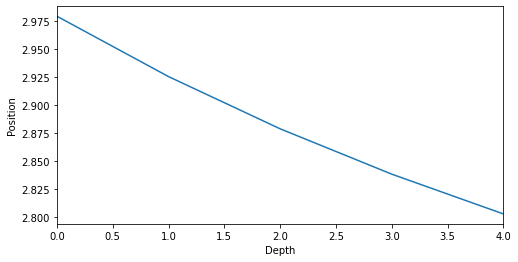

In [21]:
# data
data = {
    'loss':losses
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[8, 4])
plt.plot(losses)
plt.xlabel('Depth')
plt.xlim(0, n_epoch - 1)
plt.ylabel('Position')
plt.show()